## Effect of Daylength on Variation in SARS-CoV-2 Infection in EU Countries


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import datetime
import country_converter as coco
from tableone import TableOne
import seaborn as sn
import math
import linearmodels
import statsmodels.formula.api as smf   
import csv
import os

C:\Users\Admin\anaconda3\lib\site-packages\patsy\constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping


In [2]:
#check files in import folder are in csv format and pass warning if not
                  
dirname = "C:/Users/Admin/Documents/rcsi 2020/stats Y2 autumn/python/project/data/"

for root, dirs, files in os.walk(dirname):
    for file in files:
        if file.endswith('.csv'):
            pass
        else:
            print ("Warning! "+(file)+" is not a csv file")


Warning! Ametaanalysisofthemechanicalpropertiesoficetemplatedceramicsandmetals (1)-checkpoint.ipynb is not a csv file
Warning! Ametaanalysisofthemechanicalpropertiesoficetemplatedceramicsandmetals (1).ipynb is not a csv file
Warning! euro-exchange-rates.xlsx is not a csv file
Warning! final data temp pp.xlsx is not a csv file
Warning! Untitled-checkpoint.ipynb is not a csv file
Warning! Untitled.ipynb is not a csv file
Warning! euro-exchange-rates.xlsx is not a csv file
Warning! stats_project_DL.R is not a csv file


In [3]:
#load the data and define missing values
path = "C:/Users/Admin/Documents/rcsi 2020/stats Y2 autumn/python/project/data/"
my_missing = ['NA','NULL',' ','..','.']
ire_hosp = pd.read_csv (path + 'cases_and_hospital_data_ireland.csv', sep=',',na_values=my_missing)
ire_cases = pd.read_csv (path + 'cases_by_county_ireland.csv', sep=',',na_values=my_missing)
country_income = pd.read_csv (path +'country_income_groups.csv', sep=',',na_values=my_missing)
country_cases= pd.read_csv (path +'daily-cases-by-country.csv', sep=',',na_values=my_missing)
exchange1 = pd.read_csv (path +'euro-exchange-rates.csv', sep=',',na_values=my_missing,skiprows=1)
exchange2 = pd.read_csv (path +'euro-exchange-rates.csv', sep=',',na_values=my_missing, skiprows=1)
ire_test = pd.read_csv (path +'testing_labs_ireland.csv', sep=',',na_values=my_missing)
country_employ = pd.read_csv (path +'unemployment_by_country_by_year.csv', sep=',',na_values=my_missing,skiprows=4)
country_pop = pd.read_csv (path +'population_by_country_by_year.csv', sep=',',na_values=my_missing, skiprows=4)
ire_death = pd.read_csv (path +'deaths_ireland_2010_to_2019.csv', sep=',',skiprows=3,na_values=my_missing)
ire_employ = pd.read_csv(path +'unemployment_ireland_by_month_by_region_by_age.csv', na_values=my_missing,skiprows=3,sep=',')
EU_test = pd.read_csv(path +'weekly_testing_data_europe.csv', na_values=my_missing,sep=',')
PP = pd.read_csv(path +'final data temp pp.csv', na_values=my_missing,sep=',')

In [4]:
#clean ire_death 
ire_death=ire_death.ffill(axis=None, inplace=False, limit=None, downcast=None)
ire_death=ire_death.drop(ire_death.index[0:2])
ire_death.columns = ['death_age','sex','area','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019']
#clean ire_employ 
ire_employ=ire_employ.ffill(axis=None, inplace=False, limit=None, downcast=None)
ire_employ=ire_employ.drop(ire_employ.index[0:2])
ire_employ.columns = ['death_age','sex','area','2019MO1','2019MO2','2019MO3','2019MO4','2019MO5','2019MO6','2019MO7','2019MO8','2019MO9','2019MO10','2019MO11','2019MO12','2020MO1','2020MO2','2020MO3','2020MO4','2020MO5','2020MO6','2020MO7','2020MO8','2020MO9']


In [5]:
#extract variables of interest
employ=country_employ[['Country Code','2019']].copy()
income=country_income[['Country Code','IncomeGroup']].copy()
cases=country_cases[['countryterritoryCode','month','day','year','cases','deaths','popData2019','Cumulative_number_for_14_days_of_COVID-19_cases_per_100000']].copy()
tests=EU_test[['country_code','year_week','new_cases', 'tests_done','testing_rate', 'positivity_rate','testing_data_source']].copy()

#convert pp dates from julian dates
t=PP['jul']
t = pd.to_datetime(t, origin='julian', unit='D')
PP['date']=t


In [6]:
#each dataset expresses the date and time in a different format, change all of them to week number.

#get week numbers for dates in photoperiod dataset
date_list = []
dt = PP['date'] #List of dates
for date in dt:
    date_list.append(date.isocalendar()[1])
PP['week_no']=date_list

#get week numbers for dates in tests dataset
tests['week_no'] = tests['year_week'].str.strip().str[-2:]

#get week numbers for dates in cases dataset
date_list2=[]
cases_datetime=pd.to_datetime(cases[['year', 'month', 'day']])
for x in cases_datetime:
    date_list2.append(x.isocalendar()[1])
cases['week_no']=date_list2


In [7]:
#each dataset expresses country name in different format
#convert country names to codes in PP dataframe

#change PP from county name in string to iso-3
converter = coco.CountryConverter()
iso3_codes = PP['country'].tolist()

Ccodes=converter.convert(names = iso3_codes, src = 'name', to = 'ISO3')
PP['Country Code'] = np.array(Ccodes)

#change tests from iso-2 to iso-3 
iso3_codes_intests = tests['country_code']
iso3_codes_intests = iso3_codes_intests.replace(['EL'],'GR')
iso3_codes_intests = iso3_codes_intests.replace(['UK'],'GB')#UK and EL are not found in ISO2.  Greece EL should be GRC, UK should be GBR, EU commission key
iso3_codes_intests = iso3_codes_intests.tolist()
Ccodes1=converter.convert(names = iso3_codes_intests, src = 'ISO2', to = 'ISO3')
tests['Country Code'] = np.array(Ccodes1)


In [8]:
#merge datasets
dat = PP.copy()
dat = pd.merge(dat,employ, how='left', left_on='Country Code', right_on='Country Code')
dat = dat.rename(columns={'2019': 'unemployment'})
dat = pd.merge(dat,income, left_on='Country Code', right_on='Country Code',how='inner')
dat = dat.drop(['country','long','jul','sunrise', 'sunset', 'date'],axis=1)

#remove unused cols and rename cols in tests and cases datasets
tests = tests.drop(['year_week','country_code'],axis=1)
cases = cases.drop(['month','day','year','Cumulative_number_for_14_days_of_COVID-19_cases_per_100000'],axis=1)
cases = cases.rename(columns={'countryterritoryCode': 'Country Code'})
cases = cases.rename(columns={'popData2019': 'Pop'})

#aggreagate cases to cases per week 
cases =cases.groupby(['Country Code','week_no']).mean()


In [9]:
#merge datafiles to get analysis dataset

#check data types
tests['week_no'] = pd.to_numeric(tests.week_no, errors='coerce')

#merge cases and tests, requires merge on two colulms, Country Code and Week_no 
lookup = cases.merge(tests, on=['Country Code','week_no'],how='inner')
dat = lookup.merge(dat,on=['Country Code','week_no'],how='inner')
dat = dat.loc[:,~dat.columns.duplicated()]

#make categorical variable for country
dat["Country"] = dat["Country Code"].astype('category')
dat["IncomeGroup"] = dat["IncomeGroup"].astype('category')
dat['code'] = dat.Country.cat.codes


C:\Users\Admin\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Admin\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
C:\Users\Admin\anaconda3\lib\site-packages\tableone\tableone.py:859: RuntimeWarning: Mean of empty slice
  return f.format(np.nanmean(x.values), self._std(x))


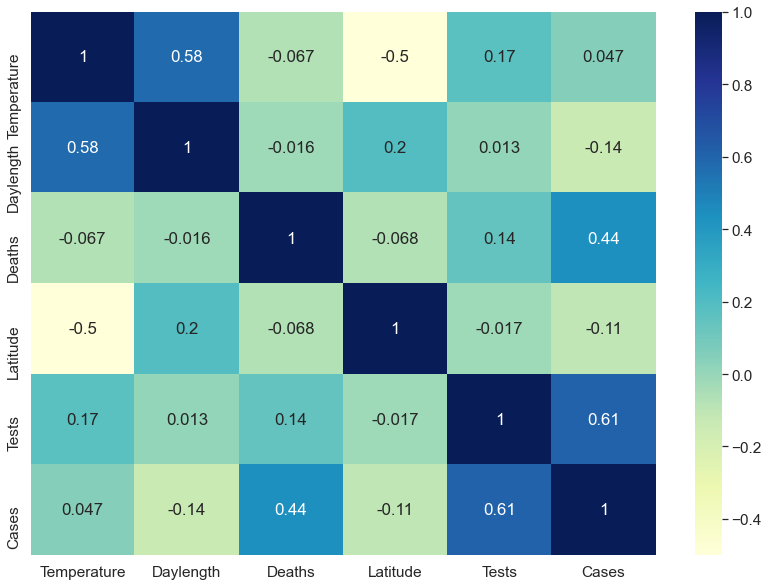

<Figure size 1008x720 with 0 Axes>

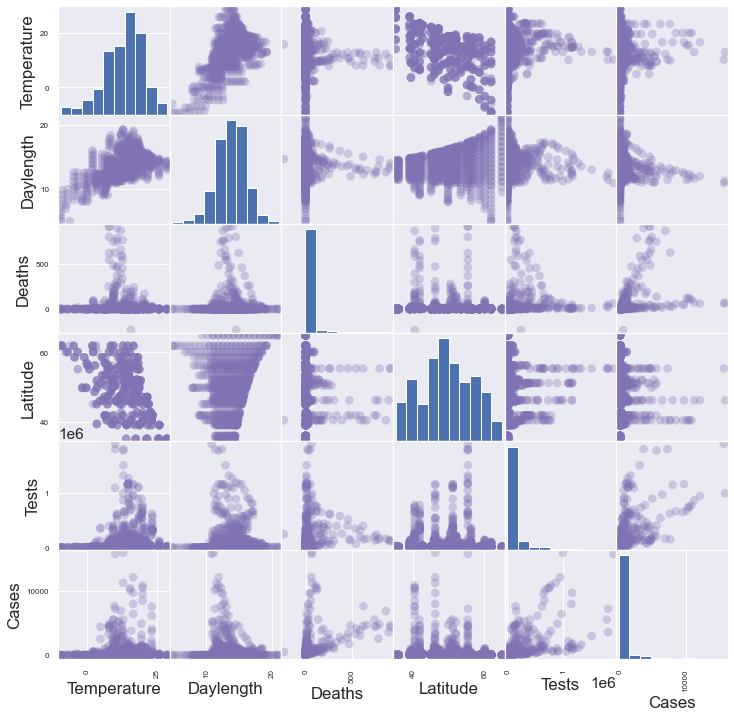

In [10]:
###############################
# EDA
###############################

#descriptive statistics tables
dat = dat.rename(columns={'Pop': 'Population','daylen': 'Daylength','unemployment': 'Unemployment','IncomeGroup': 'IncomeGroup', 'tests_done': 'Tests', 'temperature': 'Temperature','testing_rate': 'Testing Rate','positivity_rate': 'Positivity Rate','lat': 'Latitude', 'cases': 'Cases','deaths': 'Deaths'})
columns = ['Country Code','Cases','Deaths','Tests']
categorical = ['Country Code']
nonnormal = ['Cases','Deaths','Tests']
mytable = TableOne(dat, columns=columns, nonnormal=nonnormal, label_suffix=True, groupby='Country Code')
mytable.to_excel('table1.xlsx')

columns2 = ['Country Code','Population','Latitude','Unemployment','Temperature']
categorical2 = ['Country Code', 'IncomeGroup']
mytable2 = TableOne(dat, columns=columns2, label_suffix=True, groupby='Country Code')
mytable2.to_excel('table2.xlsx')

#correlation matrix
xticks=['Temperature','Daylength','Deaths', 'Latitude','Tests','Cases']
yticks=['Temperature','Daylength','Deaths', 'Latitude','Tests','Cases']
correl = dat[['Temperature','Daylength','Deaths', 'Latitude','Tests','Cases']]
corrMatrix = correl.corr()

plt.figure(figsize = (14,10))
sn.set(font_scale=1.4)
sn.heatmap(corrMatrix, annot=True, xticklabels=xticks, yticklabels=yticks, cmap="YlGnBu")
plt.savefig("plot7.pdf")

#linearity plots
plt.figure(figsize = (14,10))
ax=pd.plotting.scatter_matrix(correl,diagonal='hist',color='m', s=300,alpha = 0.3,figsize=(12,12))

plt.savefig("plot8.pdf")                


Text(0, 0.5, 'Frequency')

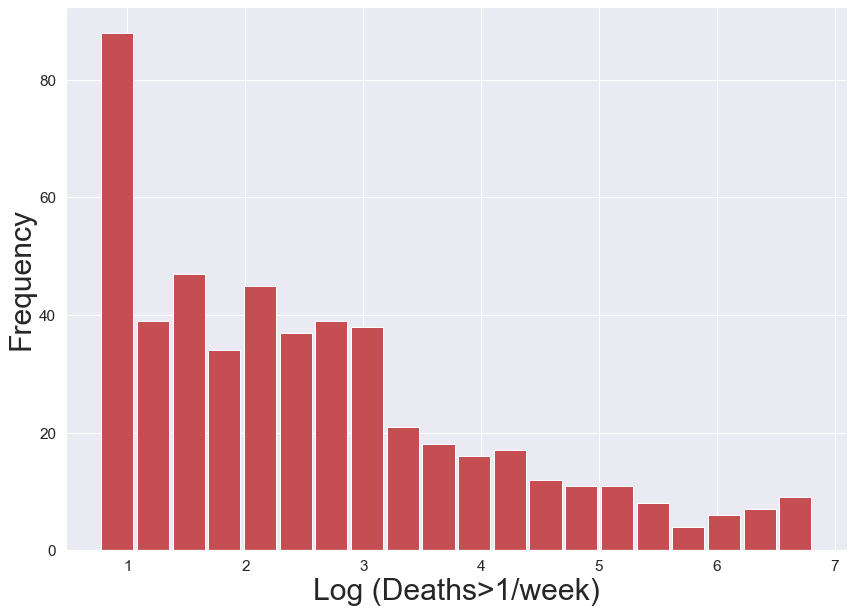

In [12]:
plt.figure(figsize = (14,10))
x=np.log(dat.Deaths[(dat.Deaths>1)]+1)
x.plot.hist(grid=True, bins=20, rwidth=0.9,color='r')
plt.xlabel('Log (Deaths>1/week)', size=30)
plt.ylabel('Frequency', size=30)
#plt.savefig("plot4.pdf")

Text(0, 0.5, 'Frequency')

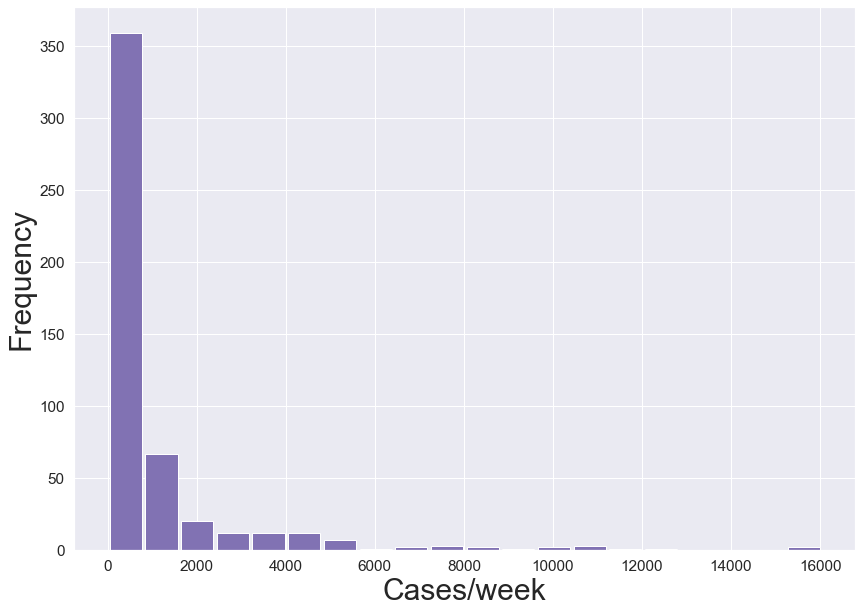

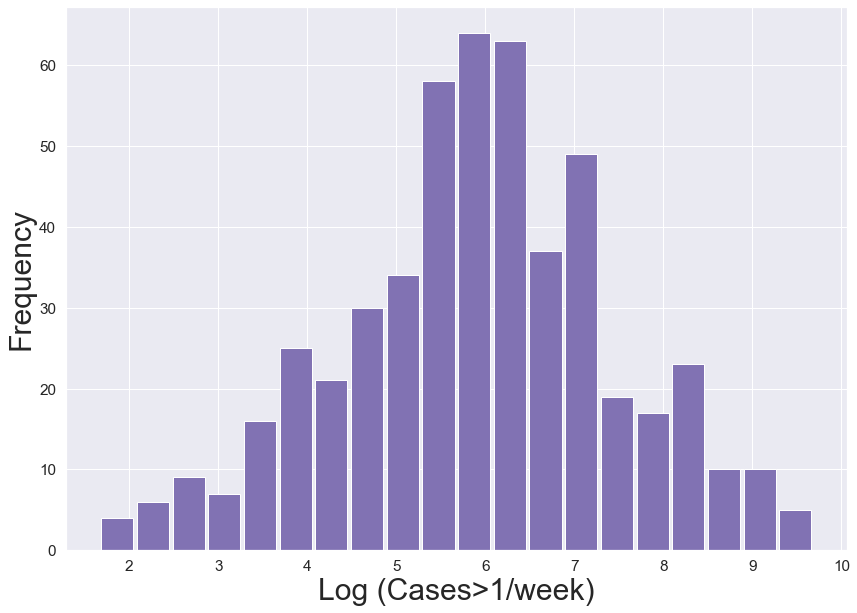

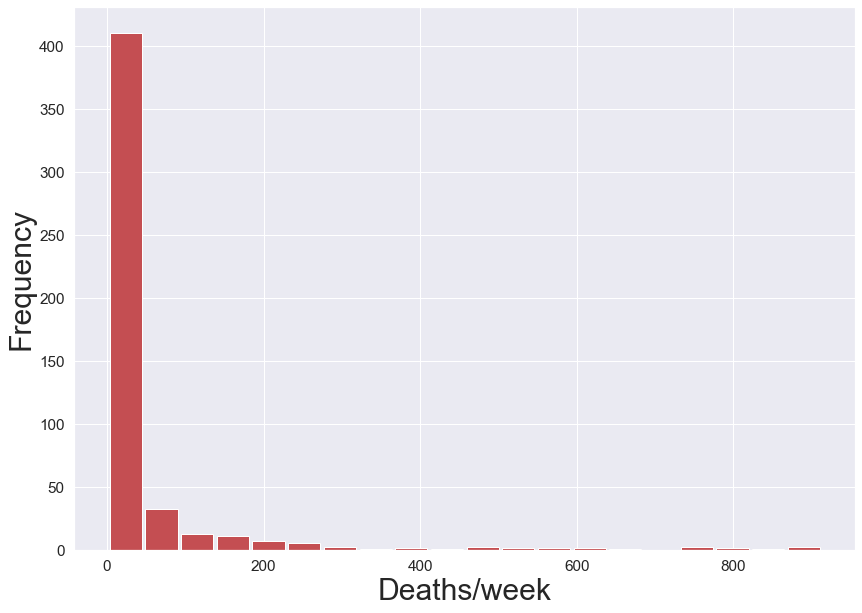

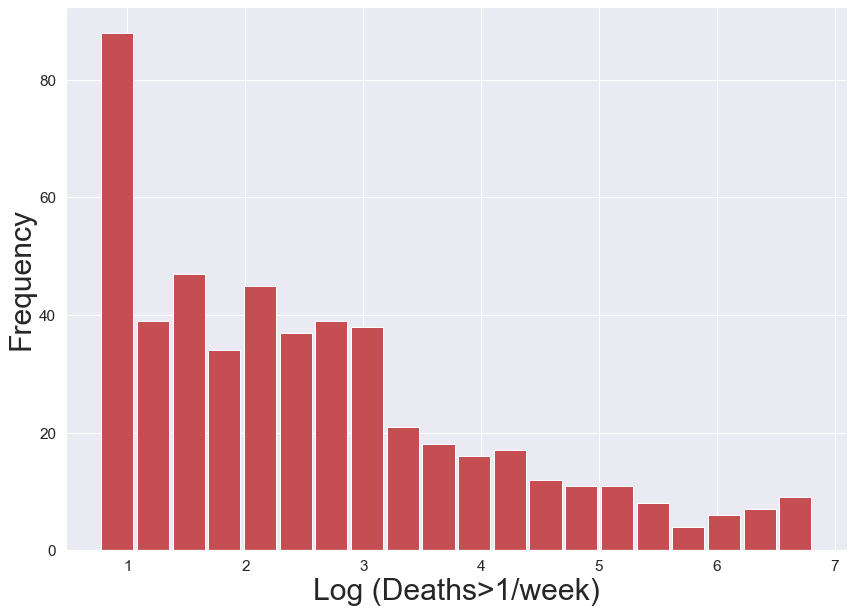

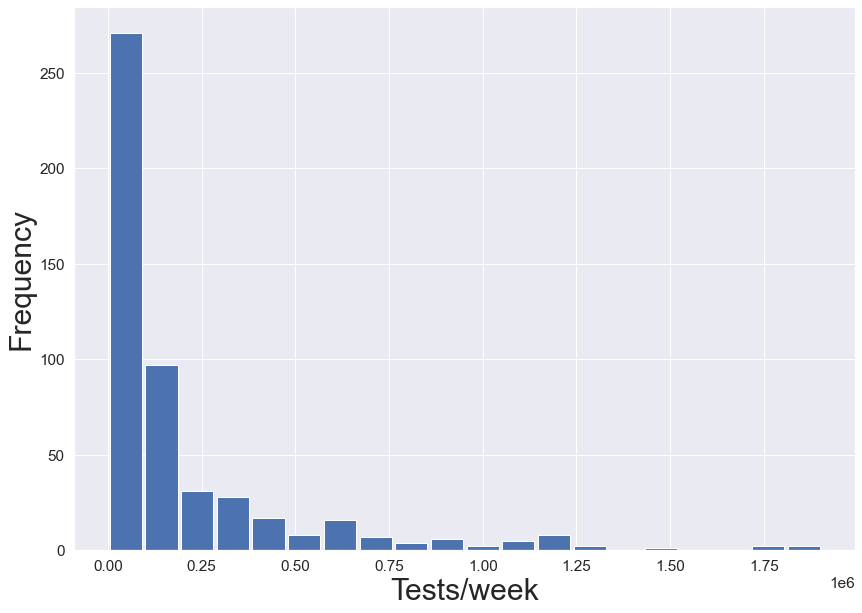

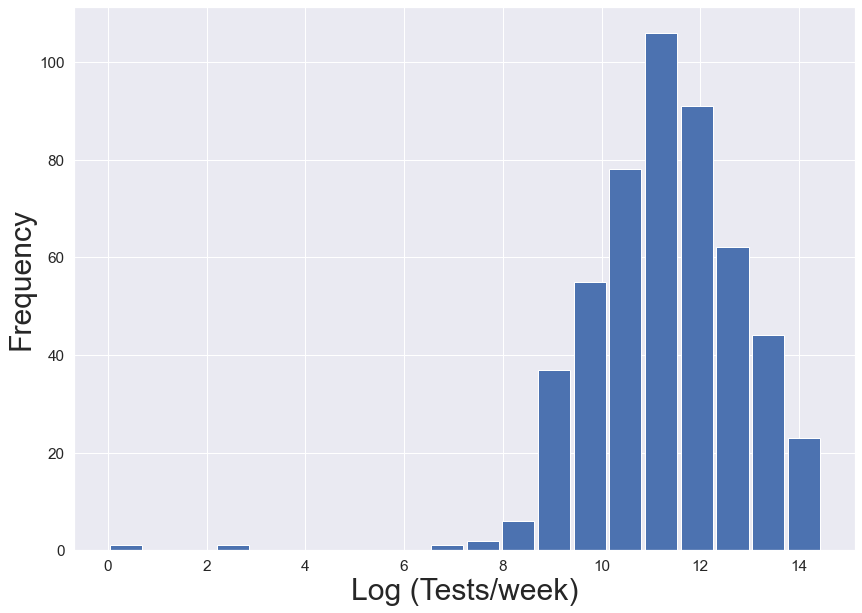

In [13]:
############################################################
#  histograms and transformation of cases, deaths and tests
############################################################

#cases
plt.figure(figsize = (14,10))
dat.Cases[(dat.Deaths>1)].plot.hist(grid=True, bins=20, rwidth=0.9,color='m')
plt.xlabel('Cases/week', size=30)
plt.ylabel('Frequency', size=30)
#plt.savefig("plot1.pdf")

plt.figure(figsize = (14,10))
x=np.log(dat.Cases[(dat.Deaths>1)]+1)
x.plot.hist(grid=True, bins=20, rwidth=0.9,color='m')
plt.xlabel('Log (Cases>1/week)', size=30)
plt.ylabel('Frequency', size=30)
#plt.savefig("plot2.pdf")

#deaths
plt.figure(figsize = (14,10))
dat.Deaths[(dat.Deaths>1)].plot.hist(grid=True, bins=20, rwidth=0.9,color='r')
plt.xlabel('Deaths/week', size=30)
plt.ylabel('Frequency', size=30)
#plt.savefig("plot3.pdf")

plt.figure(figsize = (14,10))
x=np.log(dat.Deaths[(dat.Deaths>1)]+1)
x.plot.hist(grid=True, bins=20, rwidth=0.9,color='r')
plt.xlabel('Log (Deaths>1/week)', size=30)
plt.ylabel('Frequency', size=30)
#plt.savefig("plot4.pdf")

#tests
plt.figure(figsize = (14,10))
dat.Tests[(dat.Deaths>1)].plot.hist(grid=True, bins=20, rwidth=0.9,color='b')
plt.xlabel('Tests/week', size=30)
plt.ylabel('Frequency', size=30)
#plt.savefig("plot5.pdf")

plt.figure(figsize = (14,10))
x=np.log(dat.Tests[(dat.Deaths>1)]+1)
x.plot.hist(grid=True, bins=20, rwidth=0.9,color='b')
plt.xlabel('Log (Tests/week)', size=30)
plt.ylabel('Frequency', size=30)
#plt.savefig("plot6.pdf")


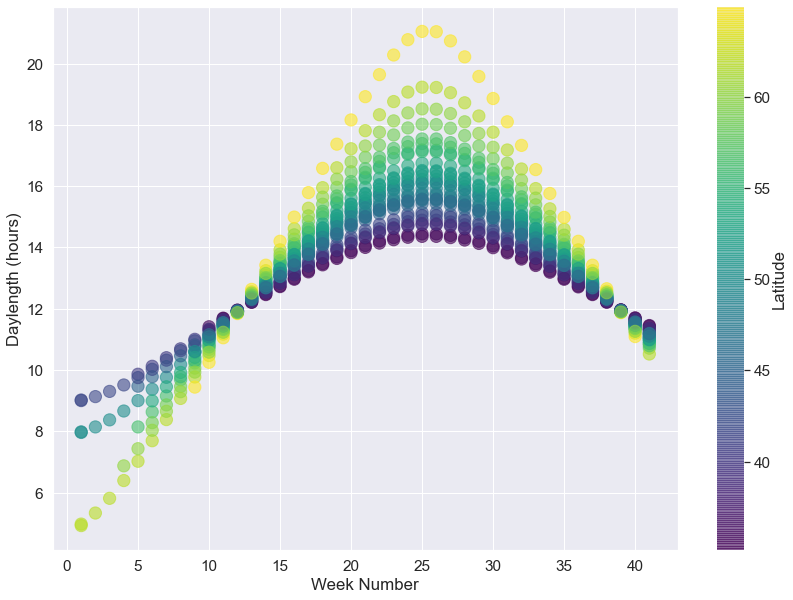

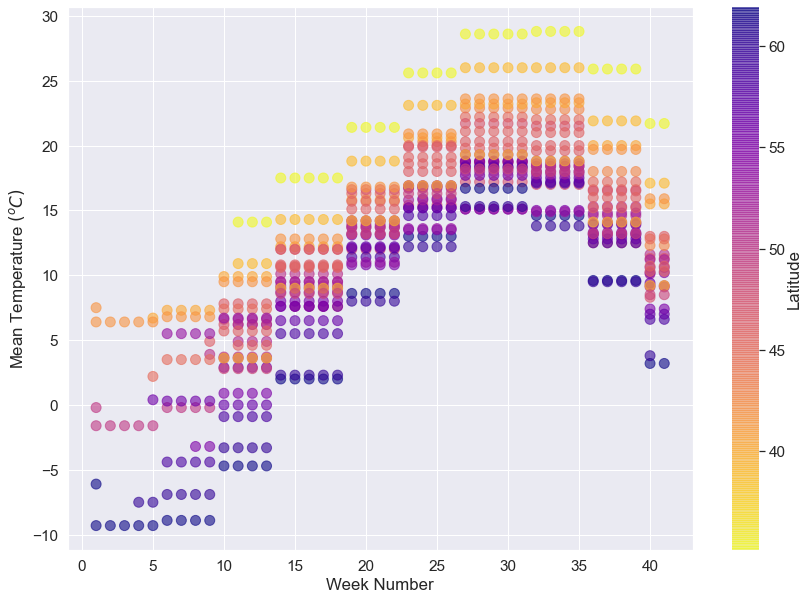

In [14]:
####################################################
# plot latitude and daylength and temperature
####################################################

plt.figure(figsize = (14,10))
plt.scatter(dat['week_no'], dat['Daylength'],150,
            c=dat['Latitude'],
            alpha=0.6 , cmap="viridis"
           )
plt.xlabel("Week Number")
plt.ylabel("Daylength (hours)")
cb=cbar= plt.colorbar()
cbar.set_label("Latitude", labelpad=+1)
cb.outline.remove()
plt.savefig("plot.pdf")

#plot latitude and temperature
plt.figure(figsize = (14,10))
plt.scatter(dat['week_no'], dat['Temperature'],100,
            c=dat['Latitude'],cmap="plasma_r",
            alpha=0.6 
           )
plt.xlabel("Week Number")
plt.ylabel("Mean Temperature $(^{o}C)$")
cb=cbar= plt.colorbar()
cbar.set_label("Latitude", labelpad=+1)
cb.outline.remove()
plt.savefig("plot6.pdf")

    

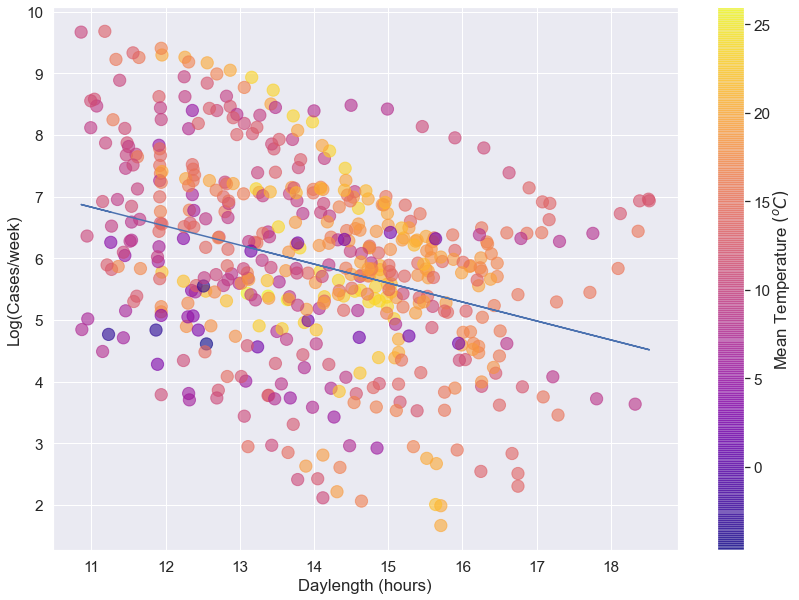

In [15]:
##############################################
# plot Cases and Daylength
##############################################
plt.figure(figsize = (14,10))
x=dat.Daylength[(dat.Deaths>1)]
y=np.log(dat.Cases[(dat.Deaths>1)]+1)

plt.scatter(x,y,150,c=dat.Temperature[(dat.Deaths>1)],cmap="plasma",alpha=0.6)
plt.xlabel("Daylength (hours)")
plt.ylabel("Log(Cases/week)")
plt.cbar= plt.colorbar()
plt.cbar.set_label("Mean Temperature $(^{o}C)$", labelpad=+1)
#add linear regression line to scatterplot 
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)

plt.savefig("plot6.pdf")
  
########################################


In [127]:
###########################
# get VIF
###########################

#subset the dataset to model variables
from statsmodels.stats.outliers_influence import variance_inflation_factor 

#make the independent variables set 
X = dat[['Temperature', 'Population','Tests','Cases', 'Deaths', 'IncomeGroup', 'Latitude','Unemployment']].dropna()
X = X[(dat.Deaths>1)]

##############################
#VIF for Model1
X1 = dat[['Temperature', 'Population','Tests','Unemployment','Daylength','Latitude']].dropna()
X1 = X1[(dat.Deaths>1)]

# VIF1 dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X1.columns 

# calculating VIF for each feature model1
vif_data["Model1"] = [variance_inflation_factor(X1.values, i) 
                          for i in range(len(X1.columns))] 
print(vif_data)

#################################
#VIF for Model2

X2 = dat[['Temperature', 'Population','Tests','Unemployment','Daylength']].dropna()
X2 = X2[(dat.Deaths>1)]
# VIF1 dataframe 
vif_data2 = pd.DataFrame() 
vif_data2["feature"] = X2.columns 

# calculating VIF for each feature Model2 
vif_data2["Model2"] = [variance_inflation_factor(X2.values, i) 
                          for i in range(len(X2.columns))] 
print(vif_data2)
#select the model
#latitude and temperature can be in the same model without exceeding VIF>4
#focus on cases, deaths depend on age and health services

        feature      Model1
0   Temperature   14.436504
1    Population    4.558197
2         Tests    3.386417
3  Unemployment    3.990079
4     Daylength  133.140802
5      Latitude   84.438443
        feature    Model2
0   Temperature  9.780401
1    Population  4.392907
2         Tests  2.944605
3  Unemployment  3.985469
4     Daylength  9.574959


<ipython-input-127-f08ef6a7d344>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X = X[(dat.Deaths>1)]
<ipython-input-127-f08ef6a7d344>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X1 = X1[(dat.Deaths>1)]
<ipython-input-127-f08ef6a7d344>:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X2 = X2[(dat.Deaths>1)]


In [139]:
########################################################################
# regression with no account for time effect and country as fixed factor
########################################################################
X=dat.copy()
X['lnCases'] =np.log(dat.Cases[(dat.Deaths>1)]+1)
reg = smf.ols('lnCases ~ Temperature + Unemployment + IncomeGroup + Population + Daylength + Tests', data=X)
reg_fit = reg.fit()
print(reg_fit.summary())


                            OLS Regression Results                            
Dep. Variable:                lnCases   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     80.36
Date:                Wed, 23 Dec 2020   Prob (F-statistic):           7.88e-70
Time:                        13:06:52   Log-Likelihood:                -749.66
No. Observations:                 499   AIC:                             1513.
Df Residuals:                     492   BIC:                             1543.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [153]:
########################################
# check model assumptions equal variance
########################################

#plot residuals x fitted
pred_val = reg_fit.fittedvalues.copy()
true_val = X['lnCases'].values.copy()
residual = true_val - pred_val

plt.figure(figsize = (14,10))
sn.residplot(residual, pred_val, 200,
                          lowess=True,
                          scatter_kws={'color': 'purple','alpha': 0.2, 's': 150},
                          line_kws={'color': 'yellow', 'lw': 1, 'alpha': 1.0, 'lw': 4})
# Set x-axis label
plt.xlabel('Fitted Values')
# Set y-axis label
plt.ylabel('Residuals')
plt.savefig("plot7.pdf")


<Figure size 1008x720 with 0 Axes>

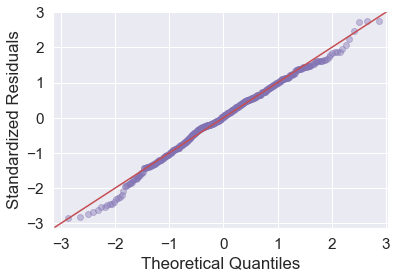

In [132]:
############################################
#  normality
############################################
from statsmodels.graphics.gofplots import ProbPlot

#reg_residuals = pred_valres_fit.resid
reg_residuals = pred_val
reg_norm_residuals = reg_fit.get_influence().resid_studentized_internal

plt.figure(figsize = (14,10))
QQ = ProbPlot(reg_norm_residuals)
pl_B = QQ.qqplot(line='45', alpha=0.4, color='m', lw=3)
pl_B.axes[0].set_xlabel('Theoretical Quantiles')
pl_B.axes[0].set_ylabel('Standardized Residuals');


#abs_norm_resid = np.flip(np.argsort(np.abs(reg_norm_residuals)), 0)
#abs_norm_resid_top_3 = abs_norm_resid[:3]
#for r, i in enumerate(abs_norm_resid_top_3):
    #pl_B.axes[0].annotate(i,xy=(np.flip(QQ.theoretical_quantiles, 0)[r],reg_norm_residuals[i]))
    
plt.savefig("plot7.pdf")

In [146]:
################################
# model with time random effect
################################
from pystout import pystout
import statsmodels.api as sm 
from linearmodels import PanelOLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

#specify time and entity effects
mi_data = X.set_index(['Country', 'week_no'])

mod =PanelOLS.from_formula('lnCases ~ 1+Temperature + Unemployment + IncomeGroup + Population + Daylength + Tests', data=mi_data)

print(mod.fit())

                          PanelOLS Estimation Summary                           
Dep. Variable:                lnCases   R-squared:                        0.4950
Estimator:                   PanelOLS   R-squared (Between):              0.5227
No. Observations:                 499   R-squared (Within):               0.3717
Date:                Wed, Dec 23 2020   R-squared (Overall):              0.4950
Time:                        13:14:31   Log-likelihood                   -749.66
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      80.364
Entities:                          29   P-value                           0.0000
Avg Obs:                       17.207   Distribution:                   F(6,492)
Min Obs:                       0.0000                                           
Max Obs:                       33.000   F-statistic (robust):             80.364
                            